In [2]:
import opensim as osim
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd

from stan_utils import *

## create reference lists

In [ ]:
folder = '00X'
ind = 'P0X'

In [ ]:
model_path = f'3a_osim_markers/scaled_model_{ind}.osim' 
model = osim.Model(model_path)
model.initSystem()
mscl_names = [force.getName() for force in model.get_ForceSet()]

In [4]:
# create a dictionary of coordinates and bodies attached
def coordinate_bodies(gen):
    coords = [coord.getName() for coord in gen.getCoordinateSet()]
    coordinate_bodies = {}
    for coord in coords:
        if 'pelvis' in coord and '_t' not in coord:
            coordinate_bodies[coord] = ['pelvis', 'torso']
        if 'hip_' in coord:
            if '_r' in coord:
                coordinate_bodies[coord] = ['pelvis', 'femur_r']
            if '_l' in coord:
                coordinate_bodies[coord] = ['pelvis', 'femur_l']
        if 'knee_' in coord and 'beta' not in coord:
            if '_r' in coord:
                coordinate_bodies[coord] = ['femur_r', 'tibia_r']
            if '_l' in coord:
                coordinate_bodies[coord] = ['femur_l', 'tibia_l']
        if 'knee_' in coord and 'beta' in coord:
            if '_r' in coord:
                coordinate_bodies[coord] = ['femur_r', 'tibia_r', 'patella_r']
            if '_l' in coord:
                coordinate_bodies[coord] = ['femur_l', 'tibia_l', 'patella_l']
        if 'ankle' in coord:
            if '_r' in coord:
                coordinate_bodies[coord] = ['tibia_r']
            if '_l' in coord:
                coordinate_bodies[coord] = ['tibia_l']
                
    return coordinate_bodies

# create a dictionary of muscles and bodies attached
def muscle_bodies(gen):
    mscl_names = [force.getName() for force in gen.get_ForceSet()]
    mscl_names = mscl_names[:-3]

    muscle_bodies_dictionary = {}
    for item in mscl_names:
        muscle_bodies_dictionary[item] = []
        muscle = gen.getMuscles().get(item)
        path = muscle.getGeometryPath()
        path_points = path.getPathPointSet()

        for i in range(path_points.getSize()):
            point = osim.PathPoint.safeDownCast(path_points.get(i))
            if not point:
                continue  # Skip invalid points
            muscle_bodies_dictionary[item].append(point.getBody().getName()) 

    return muscle_bodies_dictionary 

In [5]:
# create help dictionaries
coordinate_bodies_dictionary = coordinate_bodies(model)
muscle_bodies_dictionary = muscle_bodies(model)

In [6]:
# create muscle - coordinate dictionary
muscle_coords = {}
for muscle, bodies in muscle_bodies_dictionary.items():

    coords = []
    if 'pelvis' in bodies and '_r' in muscle:
        coords += ['hip_flexion_r', 'hip_adduction_r', 'hip_rotation_r']
    if 'pelvis' in bodies and '_l' in muscle:
        coords += ['hip_flexion_l', 'hip_adduction_l', 'hip_rotation_l']

    if 'femur_r' in bodies and 'calcn_r' in bodies:
        coords += ['knee_angle_r']
    if 'femur_l' in bodies and 'calcn_l' in bodies:
        coords += ['knee_angle_l']

    if ('tibia_r' in bodies) and ('calcn_r' not in bodies):
        coords += ['knee_angle_r']
    if ('tibia_l' in bodies) and ('calcn_l' not in bodies):
        coords += ['knee_angle_l']
        
    muscle_coords[muscle] = coords

In [7]:
# create coordinate - muscle dictionary
coord_muscles = {'hip_flexion_r':[], 'hip_adduction_r':[], 'hip_rotation_r':[], 'knee_angle_r':[], 'hip_flexion_l':[], 'hip_adduction_l':[], 'hip_rotation_l':[], 'knee_angle_l':[]}

for muscle, coords in muscle_coords.items():
    if 'hip_flexion_r' in coords:
        coord_muscles['hip_flexion_r']+=[muscle]
        coord_muscles['hip_adduction_r']+=[muscle]
        coord_muscles['hip_rotation_r']+=[muscle]
    if 'hip_flexion_l' in coords:
        coord_muscles['hip_flexion_l']+=[muscle]
        coord_muscles['hip_adduction_l']+=[muscle]
        coord_muscles['hip_rotation_l']+=[muscle]
    if 'knee_angle_r' in coords:
        coord_muscles['knee_angle_r'] += [muscle]
    if 'knee_angle_l' in coords:
        coord_muscles['knee_angle_l'] += [muscle]

## load data

In [ ]:
folders = [f'{folder}/']
individs = [f'{ind}']

In [9]:
gen_data = {'hip_flexion_r':[], 'hip_adduction_r':[], 'hip_rotation_r':[], 'knee_angle_r':[], 'hip_flexion_l':[], 'hip_adduction_l':[], 'hip_rotation_l':[], 'knee_angle_l':[]}
pers_data = {'hip_flexion_r':[], 'hip_adduction_r':[], 'hip_rotation_r':[], 'knee_angle_r':[], 'hip_flexion_l':[], 'hip_adduction_l':[], 'hip_rotation_l':[], 'knee_angle_l':[]}
optim_data = {'hip_flexion_r':[], 'hip_adduction_r':[], 'hip_rotation_r':[], 'knee_angle_r':[], 'hip_flexion_l':[], 'hip_adduction_l':[], 'hip_rotation_l':[], 'knee_angle_l':[]}

In [ ]:
def create_mean_std_dfs(data_dict, coord_name):

    gen_means = pd.DataFrame({'coords':data_dict[coord_name][0]['coords']})
    gen_means['coords'] = gen_means['coords']/np.pi*180

    for muscle in data_dict[coord_name][0].columns[1:]:
        temp = {}
        for i, ind in enumerate(individs):
            temp[ind] = data_dict[coord_name][i][muscle]
        
        temp_df = pd.DataFrame(temp)
        gen_means[muscle] = temp_df.mean(axis=1)

    return gen_means

## generic

In [ ]:
for i, folder in enumerate(folders):
    ind = individs[i]
    model_path = f'3a_osim_markers/scaled_model_{ind}.osim' 
    model = osim.Model(model_path)
    state = model.initSystem()
    for coordinate_name in gen_data.keys():
        coordinate = model.getCoordinateSet().get(coordinate_name)
        min_coord_value = coordinate.getRangeMin()
        max_coord_value = coordinate.getRangeMax()
        coord_values = np.linspace(min_coord_value, max_coord_value, 50)
        df = pd.DataFrame({'coords': coord_values})
        for muscle_name in coord_muscles[coordinate_name]:
            moment_arms = []
            muscle = osim.Muscle.safeDownCast(model.getForceSet().get(muscle_name))
            model.realizeVelocity(state)
            for value in coord_values:
                coordinate.setValue(state, value)
                moment_arm = muscle.computeMomentArm(state, coordinate)
                moment_arms.append(moment_arm)
            df[muscle_name] = moment_arms
        gen_data[coordinate_name].append(df)

In [ ]:
gen_hip_flexion_r_mean= create_mean_std_dfs(gen_data, 'hip_flexion_r')
gen_hip_adduction_r_mean = create_mean_std_dfs(gen_data, 'hip_adduction_r')
gen_hip_rotation_r_mean = create_mean_std_dfs(gen_data, 'hip_rotation_r')
gen_knee_angle_r_mean= create_mean_std_dfs(gen_data, 'knee_angle_r')

gen_hip_flexion_l_mean = create_mean_std_dfs(gen_data, 'hip_flexion_l')
gen_hip_adduction_l_mean= create_mean_std_dfs(gen_data, 'hip_adduction_l')
gen_hip_rotation_l_mean = create_mean_std_dfs(gen_data, 'hip_rotation_l')
gen_knee_angle_l_mean = create_mean_std_dfs(gen_data, 'knee_angle_l')


## personal

In [ ]:
for i, folder in enumerate(folders):
    ind = individs[i]
    model_path = f'4_tps-bones-muscles-updated/{ind}_tps_fibres_skin_wrp_updated.osim'
    model = osim.Model(model_path)
    state = model.initSystem()
    for coordinate_name in gen_data.keys():
        coordinate = model.getCoordinateSet().get(coordinate_name)
        min_coord_value = coordinate.getRangeMin()
        max_coord_value = coordinate.getRangeMax()
        coord_values = np.linspace(min_coord_value, max_coord_value, 50)
        df = pd.DataFrame({'coords': coord_values})
        for muscle_name in coord_muscles[coordinate_name]:
            moment_arms = []
            muscle = osim.Muscle.safeDownCast(model.getForceSet().get(muscle_name))
            model.realizeVelocity(state)
            for value in coord_values:
                coordinate.setValue(state, value)
                moment_arm = muscle.computeMomentArm(state, coordinate)
                moment_arms.append(moment_arm)
            df[muscle_name] = moment_arms
        pers_data[coordinate_name].append(df)

In [ ]:
pers_hip_flexion_r_mean = create_mean_std_dfs(pers_data, 'hip_flexion_r')
pers_hip_adduction_r_mean = create_mean_std_dfs(pers_data, 'hip_adduction_r')
pers_hip_rotation_r_mean = create_mean_std_dfs(pers_data, 'hip_rotation_r')
pers_knee_angle_r_mean = create_mean_std_dfs(pers_data, 'knee_angle_r')

pers_hip_flexion_l_mean = create_mean_std_dfs(pers_data, 'hip_flexion_l')
pers_hip_adduction_l_mean = create_mean_std_dfs(pers_data, 'hip_adduction_l')
pers_hip_rotation_l_mean = create_mean_std_dfs(pers_data, 'hip_rotation_l')
pers_knee_angle_l_mean = create_mean_std_dfs(pers_data, 'knee_angle_l')

## define plot function

In [ ]:
from matplotlib.lines import Line2D
def plot_gen_pers(gen_mean_table,  pers_mean_table,  name, ncols = 4):
    cols = ncols
    rows = int(np.ceil((gen_mean_table.shape[1]-1)/cols))

    fig, axs = plt.subplots(rows, cols, figsize = (cols*4, rows*3))
    fig.suptitle(f'muscle moment arms, {name}', fontsize=18, y=1.04)
    fig.subplots_adjust(top=1, bottom=0.1, wspace=0.2, hspace=0.5)
    axs = axs.flatten()

    fields = list(gen_mean_table.columns)[1:]
    x = gen_mean_table['coords']

    for i, field in enumerate(fields):

            ax = axs[i]
            ax.plot(x, gen_mean_table[field], color='gray', label='generic', linestyle='--')

            ax.plot(x, pers_mean_table[field], color='red', label='personal', linestyle='-')
            
            ax.set_title(two_line_label(field))

    for ax in axs[len(fields):]:
        ax.set_visible(False)
        
    custom_legend = [
        Line2D([0], [0], color="grey", lw=2, linestyle="--", label="generic"),
        Line2D([0], [0], color="red", lw=2, linestyle="-", label="personalised"),
    ]
    fig.legend(
        handles=custom_legend,
        loc='upper center', bbox_to_anchor=(0.5, 1.025),
        ncol=4, fontsize=11,
    )
    plt.show()

## execute

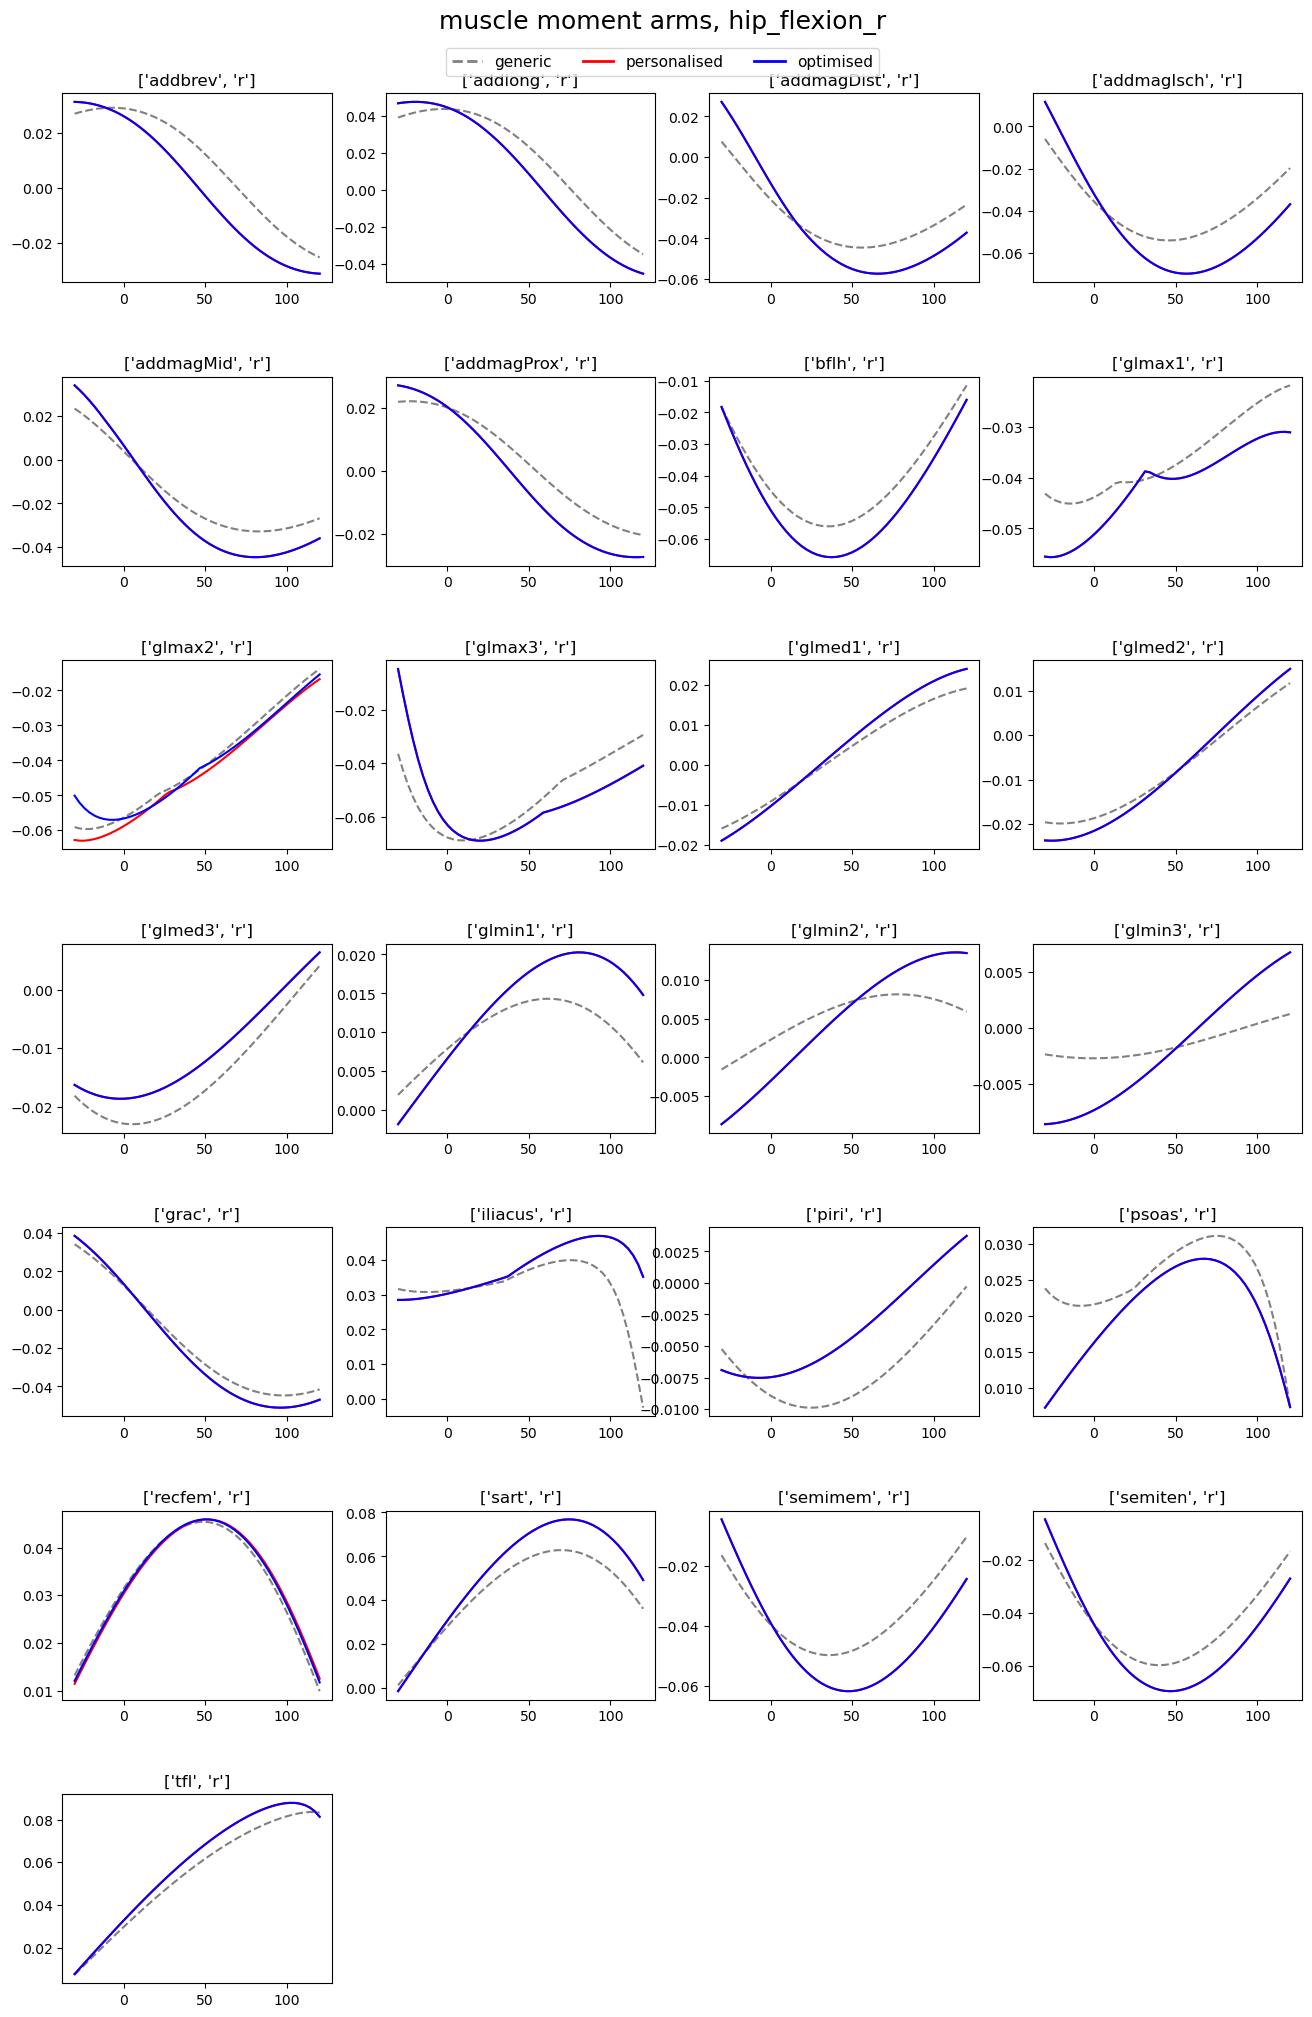

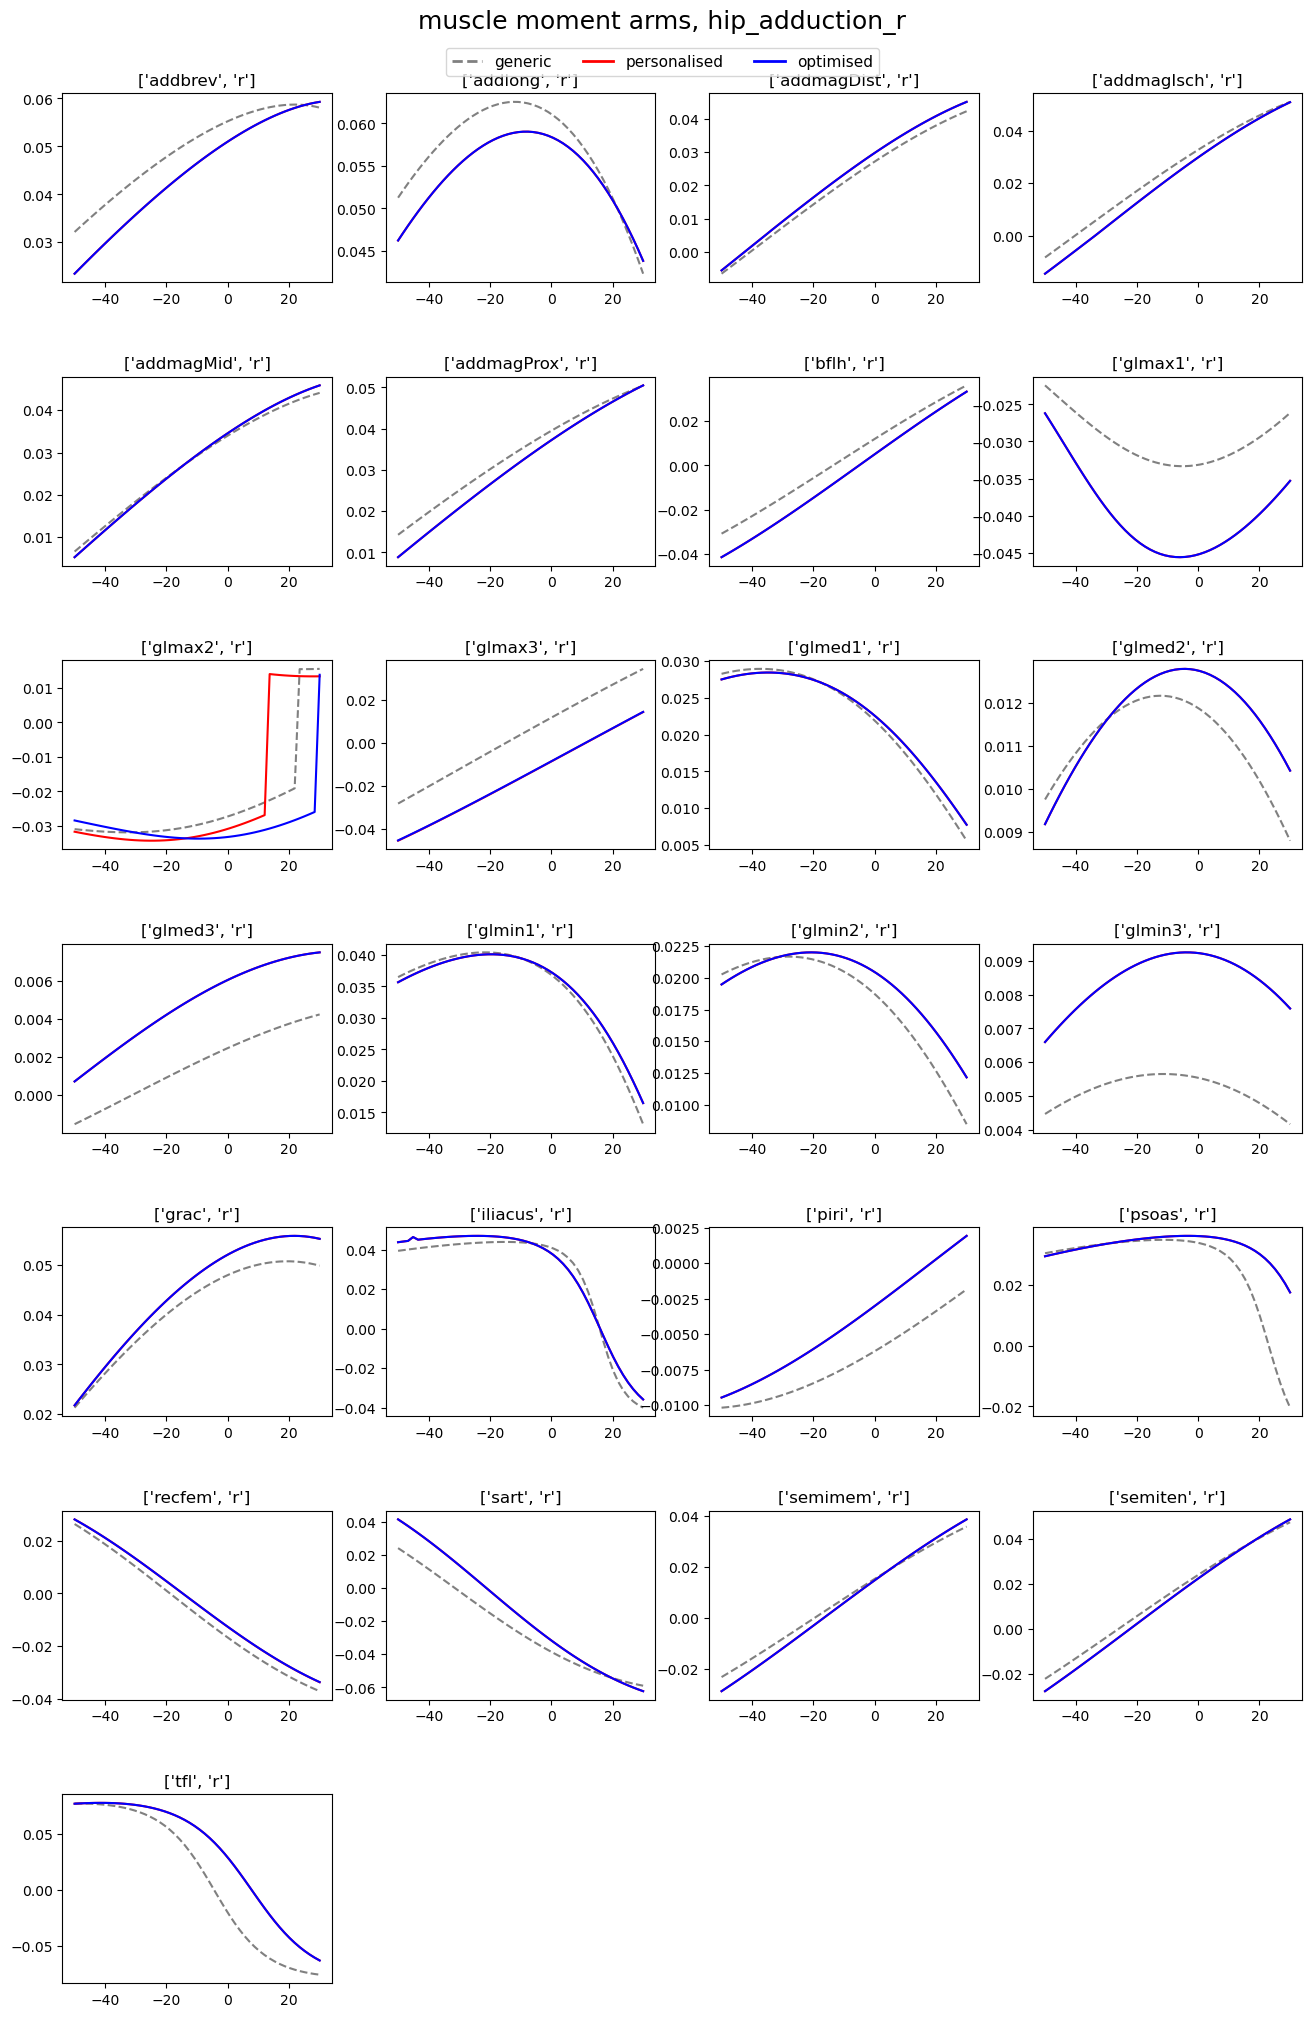

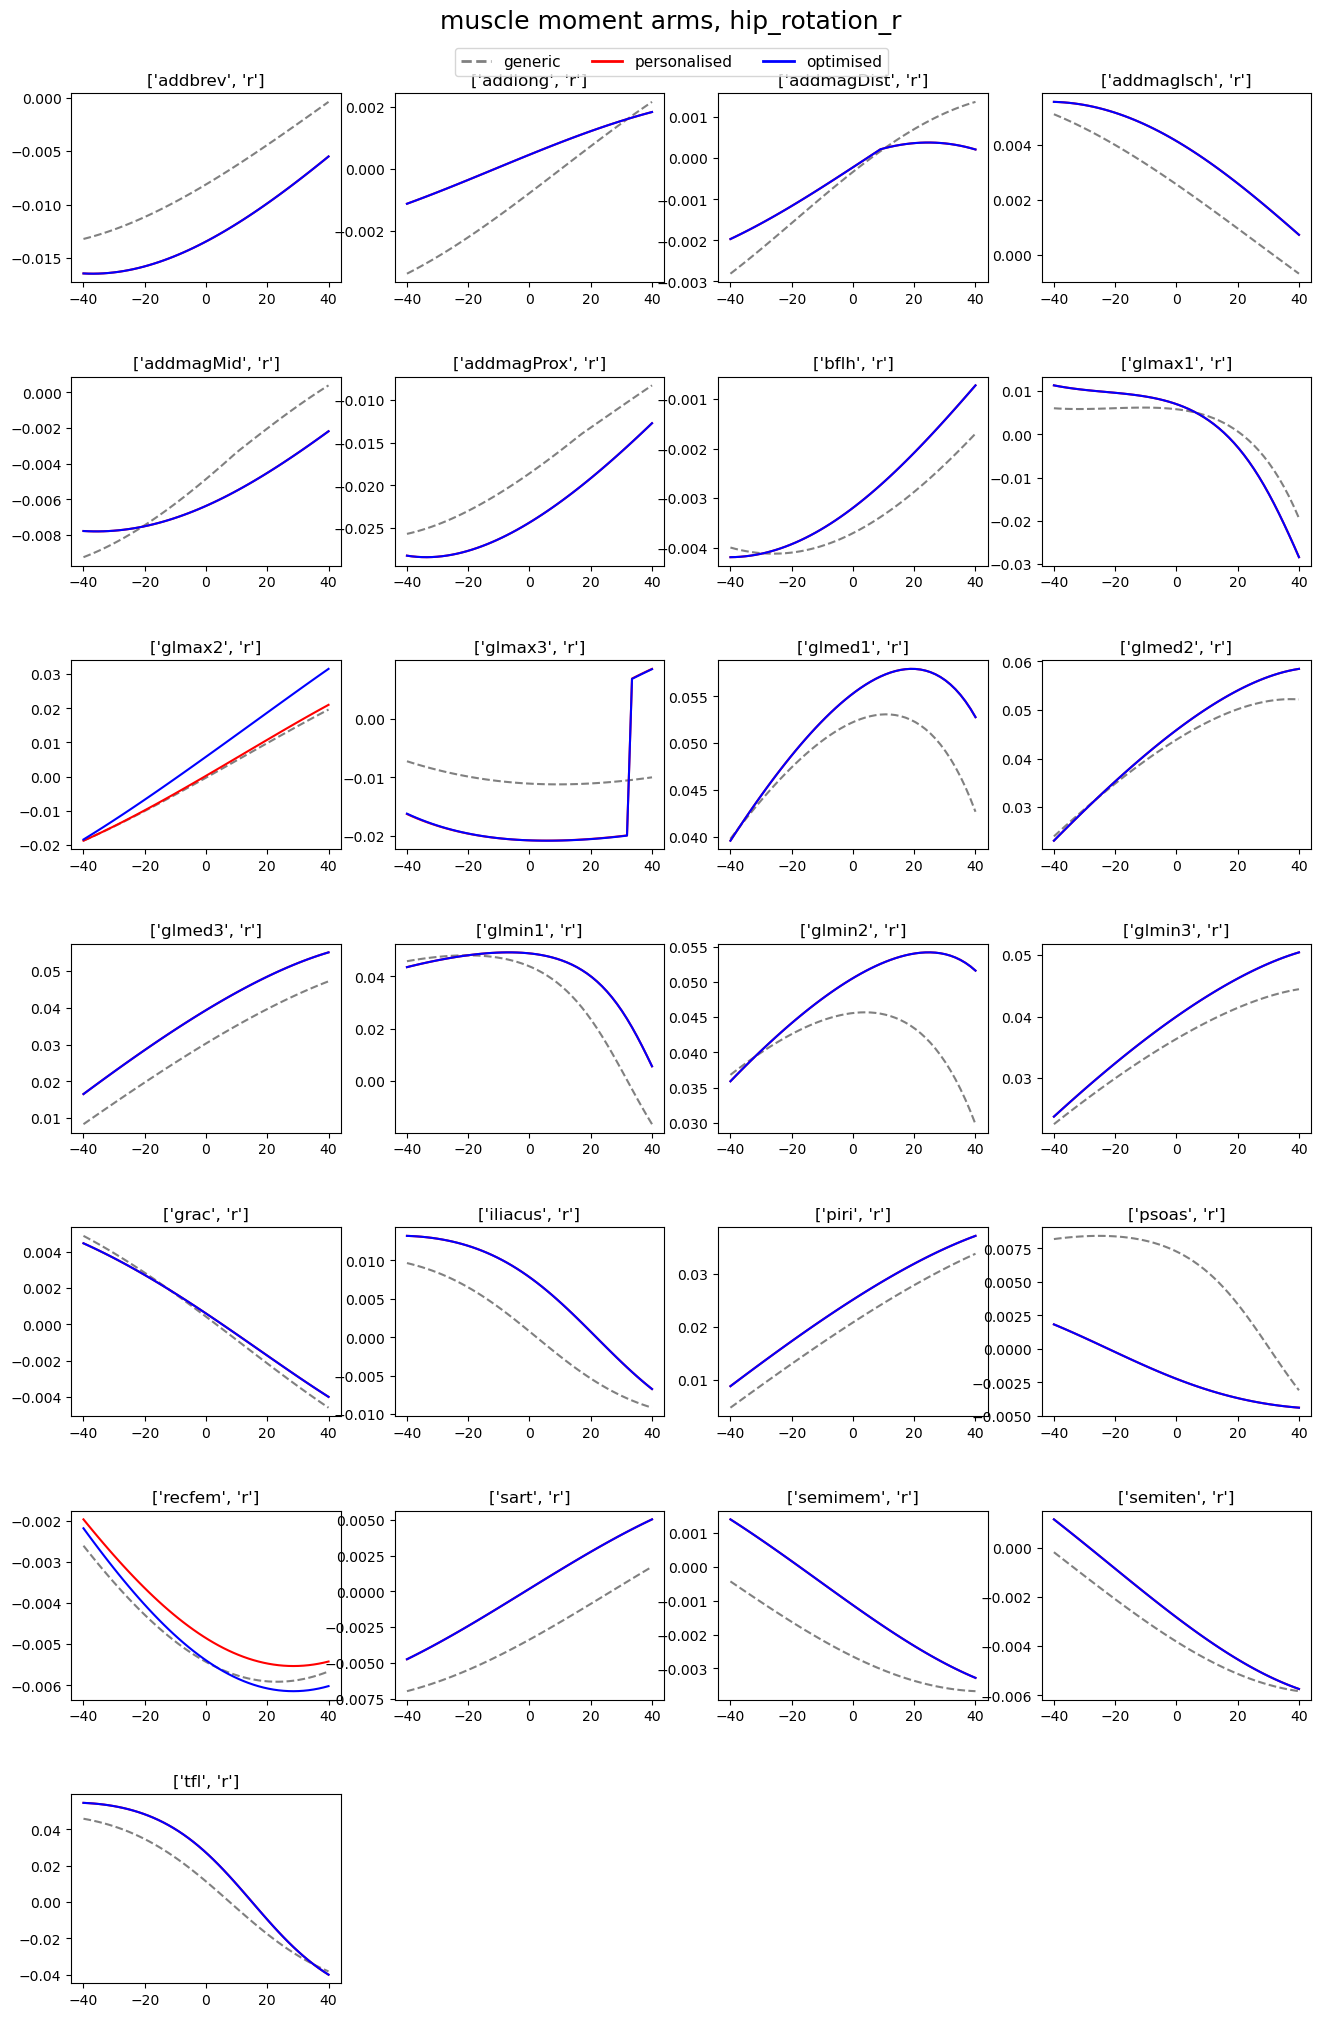

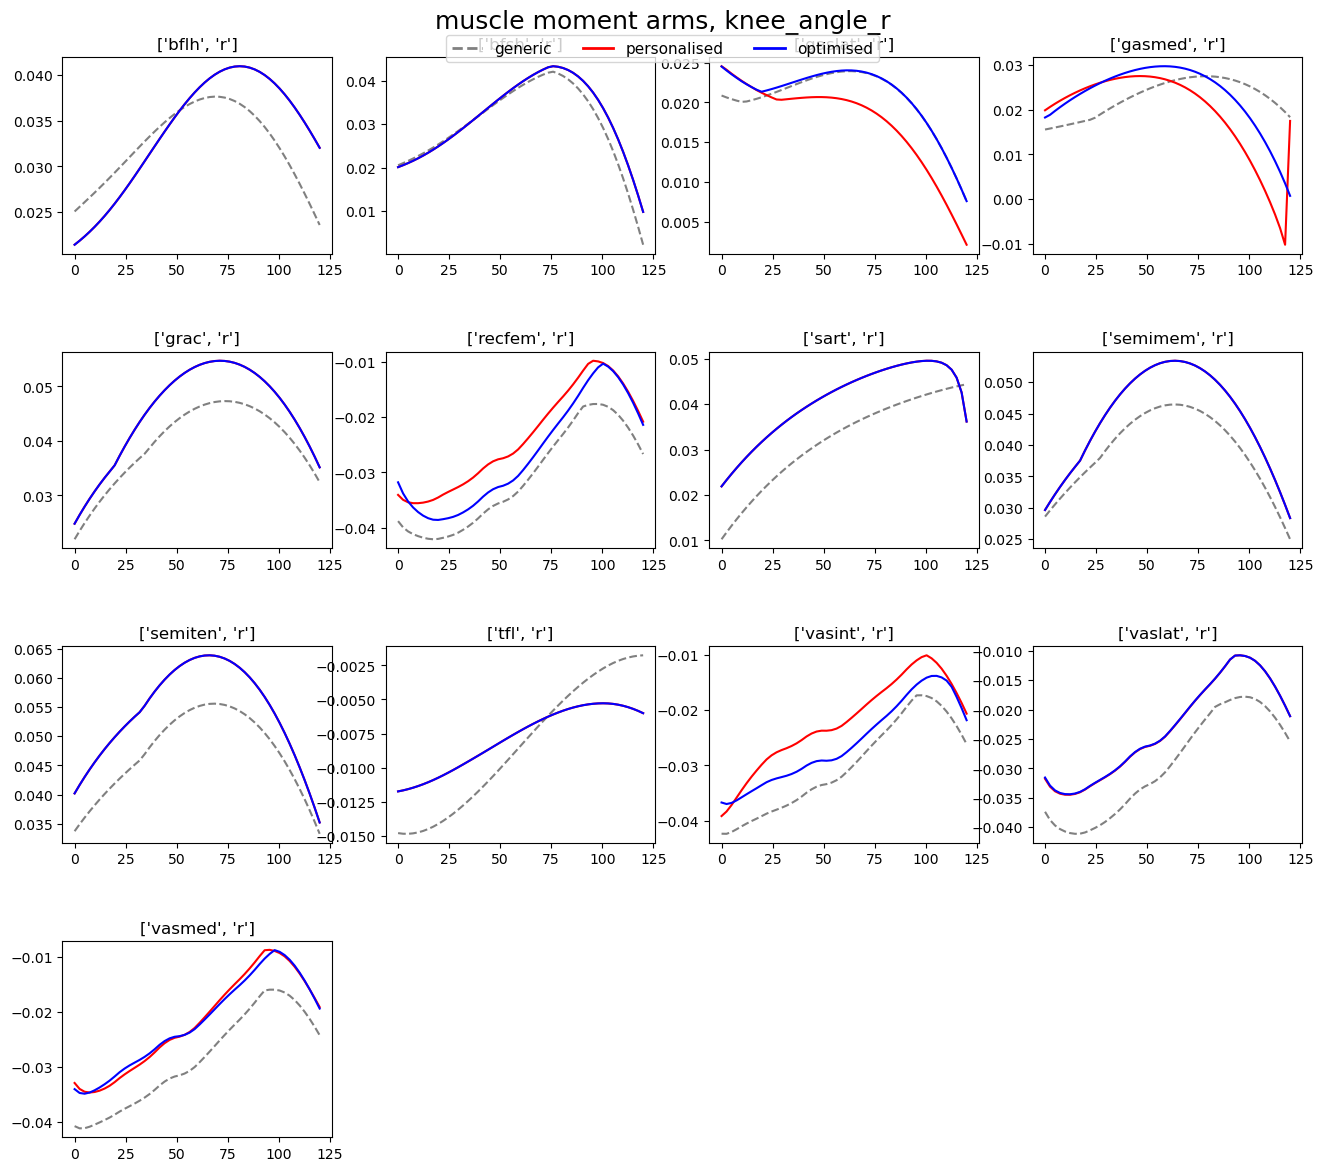

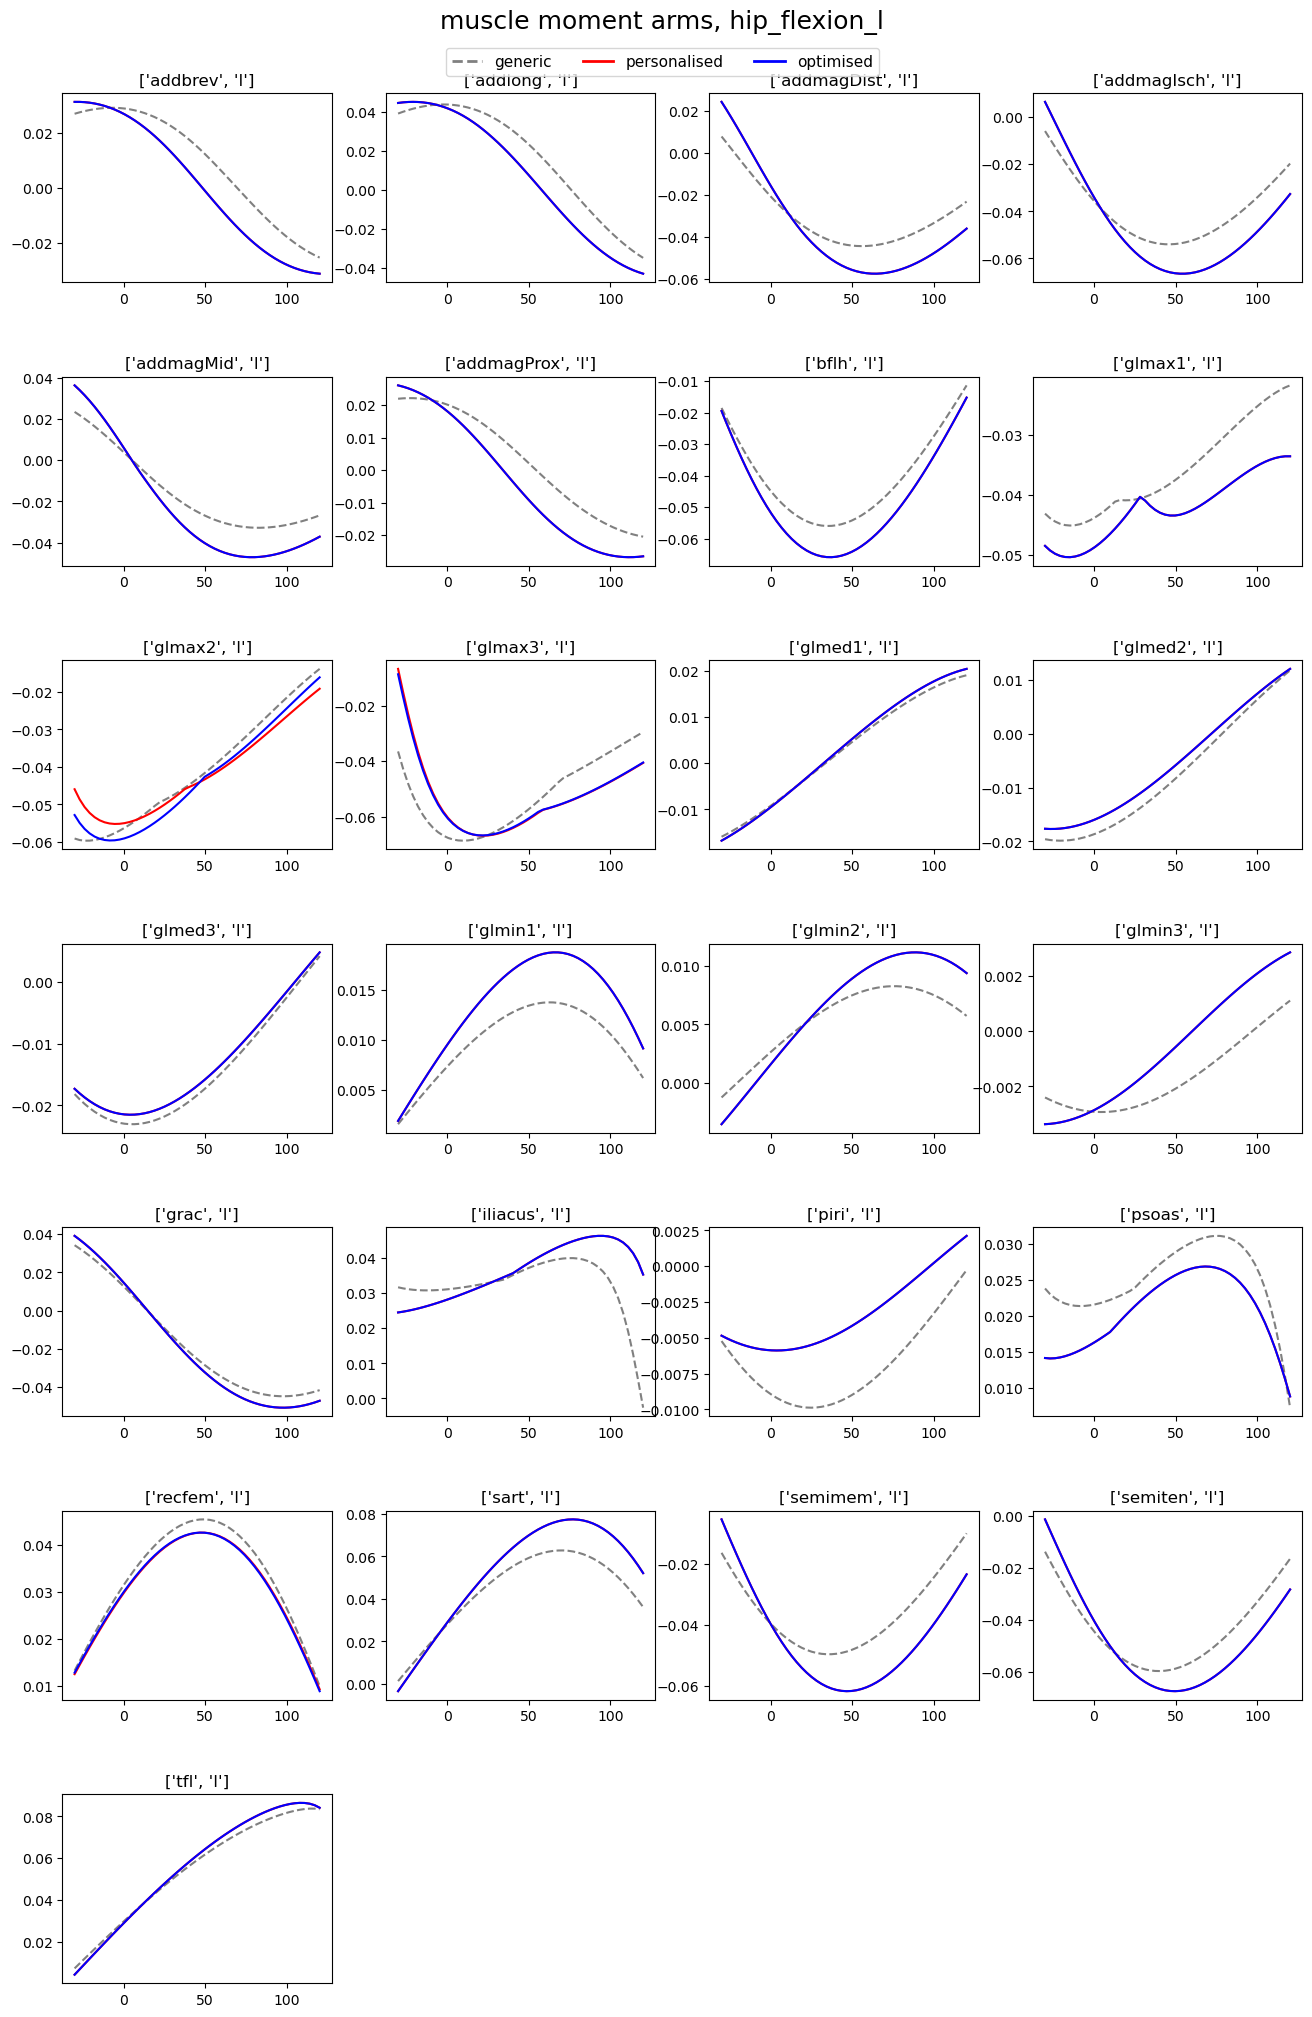

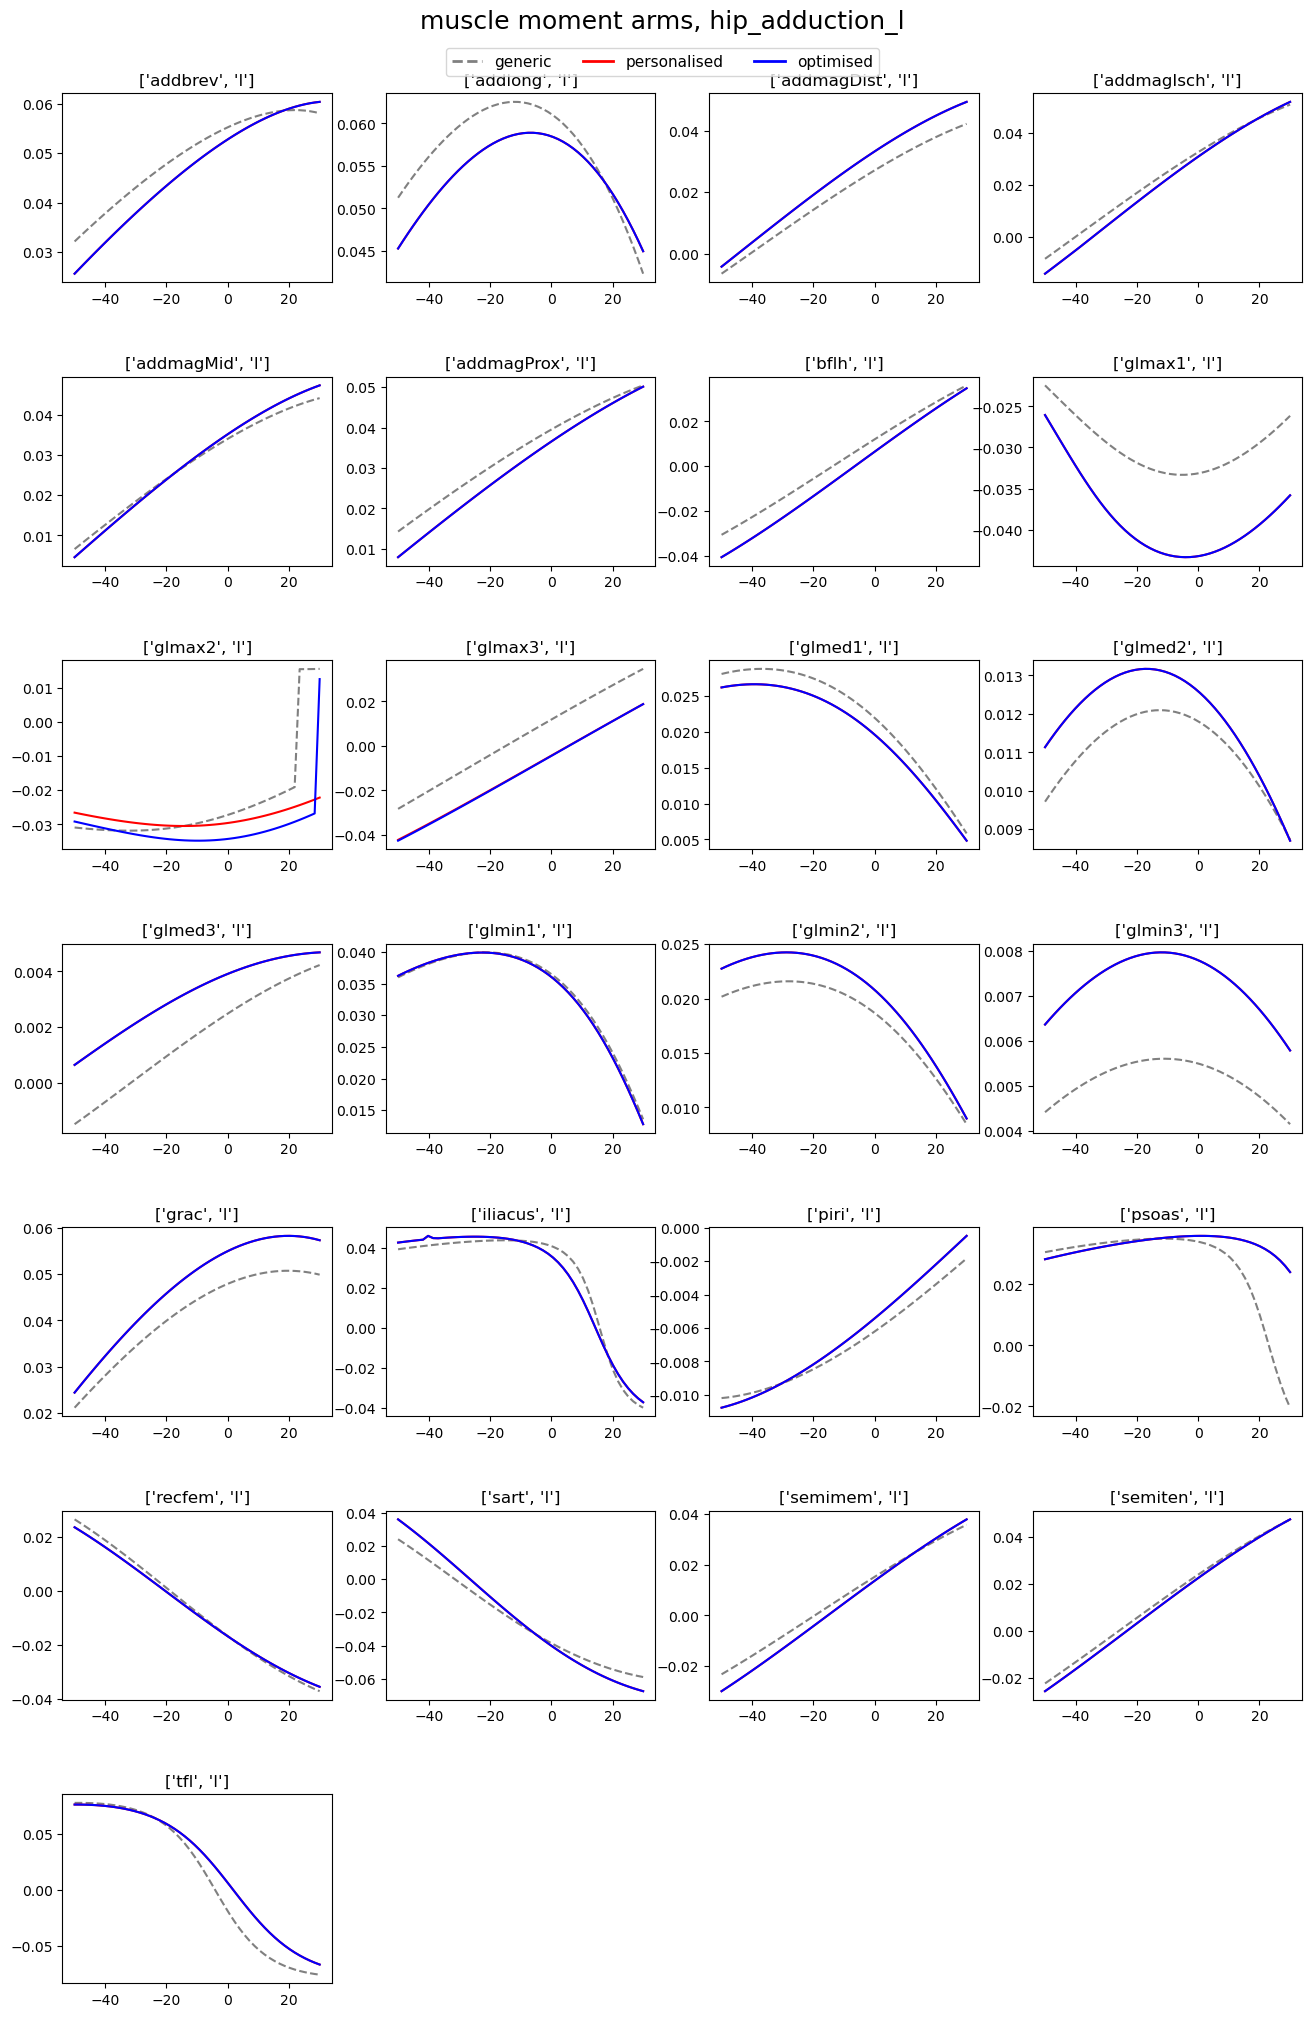

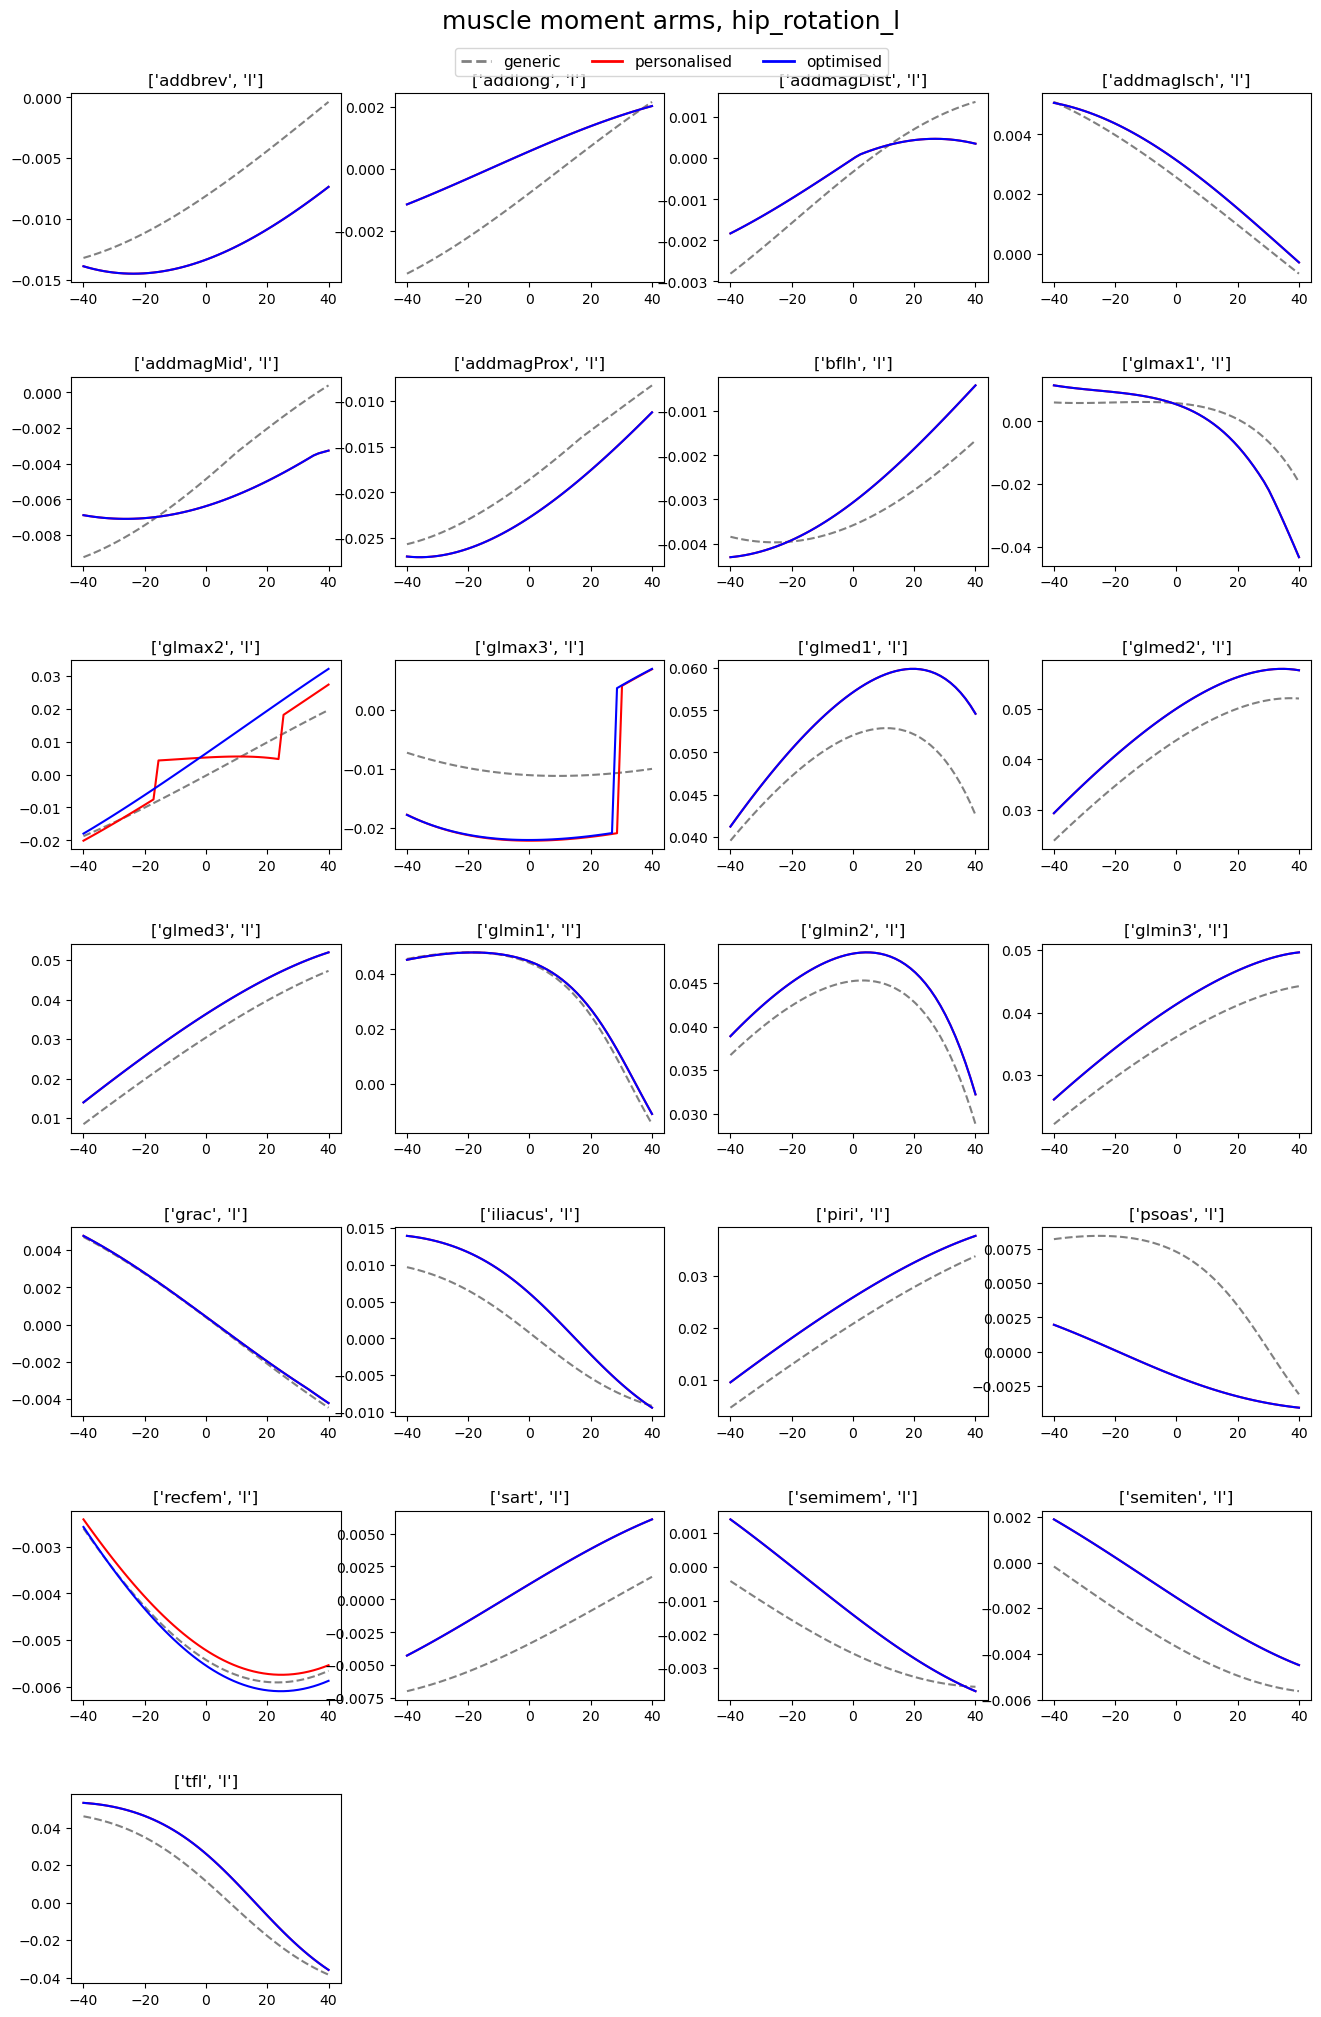

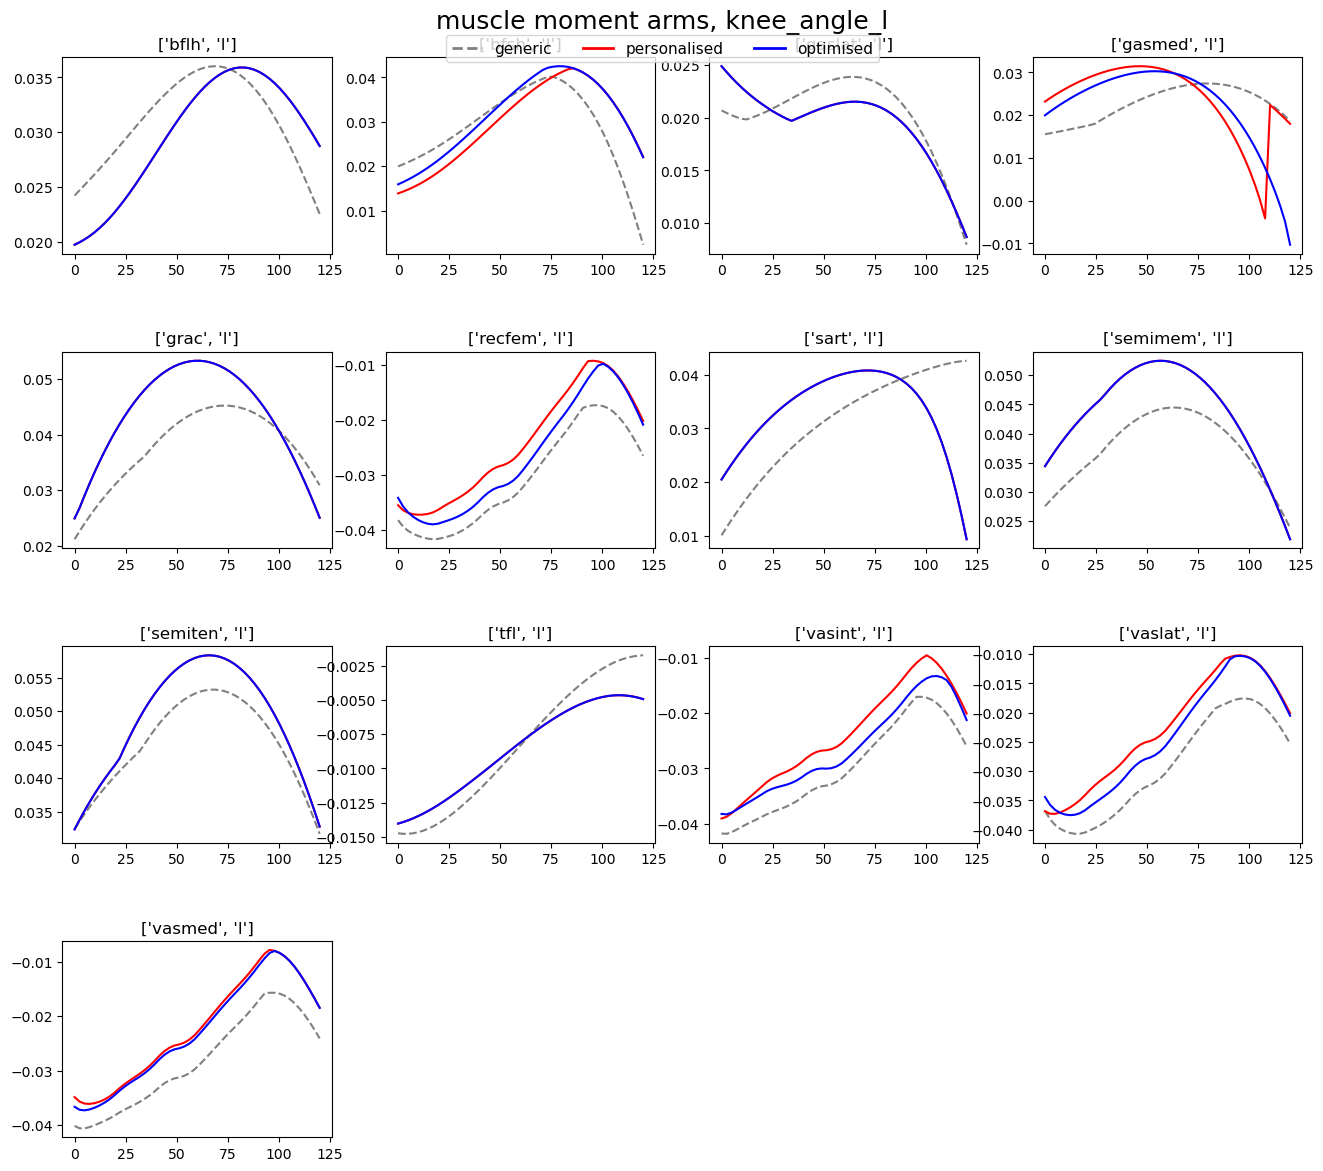

In [ ]:
plot_gen_pers(gen_hip_flexion_r_mean,  
            pers_hip_flexion_r_mean,            
            'hip_flexion_r', ncols = 4)
            
plot_gen_pers(gen_hip_adduction_r_mean, 
            pers_hip_adduction_r_mean,  
            'hip_adduction_r', ncols = 4)

plot_gen_pers(gen_hip_rotation_r_mean, 
            pers_hip_rotation_r_mean, 
            'hip_rotation_r', ncols = 4)

plot_gen_pers(gen_knee_angle_r_mean, 
            pers_knee_angle_r_mean, 
            'knee_angle_r', ncols = 4)

plot_gen_pers(gen_hip_flexion_l_mean,  
            pers_hip_flexion_l_mean,  
            'hip_flexion_l', ncols = 4)

plot_gen_pers(gen_hip_adduction_l_mean, 
            pers_hip_adduction_l_mean, 
            'hip_adduction_l', ncols = 4)

plot_gen_pers(gen_hip_rotation_l_mean, 
            pers_hip_rotation_l_mean, 
            'hip_rotation_l', ncols = 4)

plot_gen_pers(gen_knee_angle_l_mean, 
            pers_knee_angle_l_mean, 
            'knee_angle_l', ncols = 4)